In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

# Load images
def load_images(input_dir, target_dir, img_size, max_images=1000):
    input_images = []
    target_images = []
    input_filenames = os.listdir(input_dir)[:max_images]
    target_filenames = os.listdir(target_dir)[:max_images]
    
    for img_name in input_filenames:
        input_img_path = os.path.join(input_dir, img_name)
        target_img_path = os.path.join(target_dir, img_name)
        
        if os.path.exists(target_img_path):
            try:
                input_img = load_img(input_img_path, target_size=img_size)
                target_img = load_img(target_img_path, target_size=img_size)
                input_images.append(img_to_array(input_img))
                target_images.append(img_to_array(target_img))
                print(f"Loaded {img_name}")
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
        else:
            print(f"Target image not found for {img_name}")
    
    return np.array(input_images), np.array(target_images)

# Define UResNet model
def build_uresnet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)
    
        # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Custom callback to calculate and save the best PSNR model
class PSNRAndSaveModelCallback(Callback):
    def __init__(self, X_val, y_val, model_save_path):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.best_psnr = -np.inf
        self.model_save_path = model_save_path

    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.X_val)
        val_psnr = tf.image.psnr(self.y_val, val_pred, max_val=1.0).numpy().mean()
        print(f'Epoch {epoch + 1}: Val PSNR: {val_psnr:.4f}')

        # Save model after every epoch
        epoch_model_path = f'{self.model_save_path}_epoch_{epoch + 1}.h5'
        self.model.save(epoch_model_path)
        print(f'Saved model for epoch {epoch + 1} at {epoch_model_path}')

        # Save the best model based on PSNR
        if val_psnr > self.best_psnr:
            self.best_psnr = val_psnr
            best_model_path = f'{self.model_save_path}_best.h5'
            self.model.save(best_model_path)
            print(f'New best model saved with PSNR: {val_psnr:.4f} at {best_model_path}')

            
            
# Set paths and parameters
input_dir = '/kaggle/input/underwaterimages/underwater_dark/trainA'
target_dir = '/kaggle/input/underwaterimages/underwater_dark/trainB'
img_size = (256, 256)
model_save_path = 'uresnet_underwater_model'

# Load images
print("Loading images...")
input_images, target_images = load_images(input_dir, target_dir, img_size, max_images=1000)
print("Finished loading images.")

# Normalize images
input_images = input_images / 255.0
target_images = target_images / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_images, target_images, test_size=0.1, random_state=42)

# Build UResNet model
model = build_uresnet((256, 256, 3))

# Adaptive Learning Rate Callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# PSNR and Save Model Callback
psnr_callback = PSNRAndSaveModelCallback(X_val, y_val, model_save_path)

from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_psnr',  # Metric to monitor
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode, 1 = prints messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


# Train the model
print("Training the model...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[psnr_callback, reduce_lr])
print("Finished training.")



2024-08-19 16:41:11.006426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 16:41:11.006549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 16:41:11.293733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading images...
Loaded 273370_00016539.jpg
Loaded 266208_00006275.jpg
Loaded 264475_00003067.jpg
Loaded 269936_n02643566_4066.JPEG
Loaded 265975_00033705.jpg
Loaded 272324_00039472.jpg
Loaded 269190_00019195.jpg
Loaded 271592_n01914609_8454.JPEG
Loaded 268697_n02643566_89.JPEG
Loaded 267931_n02319095_7182.JPEG
Loaded 267377_00016493.jpg
Loaded 270462_00021978.jpg
Loaded 268010_00013418.jpg
Loaded 266973_n02606052_556.JPEG
Loaded 270262_00010226.jpg
Loaded 271306_n01917289_255.JPEG
Loaded 272823_00026816.jpg
Loaded 267067_scuba_lake_mead_804.jpg
Loaded 269797_00035291.jpg
Loaded 273313_n01751748_4685.JPEG
Loaded 271286_sea_turtle_coral_reef_11.jpg
Loaded 267143_n02321529_1142.JPEG
Loaded 264432_00013919.jpg
Loaded 265305_00012516.jpg
Loaded 266899_scuba_christmas_358.jpg
Loaded 270988_00032098.jpg
Loaded 273256_00017950.jpg
Loaded 269028_00007505.jpg
Loaded 269873_00037877.jpg
Loaded 272013_n02607072_1548.JPEG
Loaded 266428_n02526121_5236.JPEG
Loaded 269879_00033197.jpg
Loaded 265291_

2024-08-19 16:44:40.899926: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-19 16:44:43.752059: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.852221674s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-19 16:44:47.876902: E external/

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step- loss
Epoch 1: Val PSNR: 19.1024
Saved model for epoch 1 at uresnet_underwater_model_epoch_1.h5
New best model saved with PSNR: 19.1024 at uresnet_underwater_model_best.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - loss: 0.0609 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step- loss:
Epoch 2: Val PSNR: 19.4063
Saved model for epoch 2 at uresnet_underwater_model_epoch_2.h5
New best model saved with PSNR: 19.4063 at uresnet_underwater_model_best.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0158 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step- loss:
Epoch 3: Val PSNR: 19.8031
Saved model for epoch 3 at uresnet_underwater_model_epoch_3.h5
New best model saved with PSNR: 19.8031 at uresnet_underwater_model_best.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0148 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step- 

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


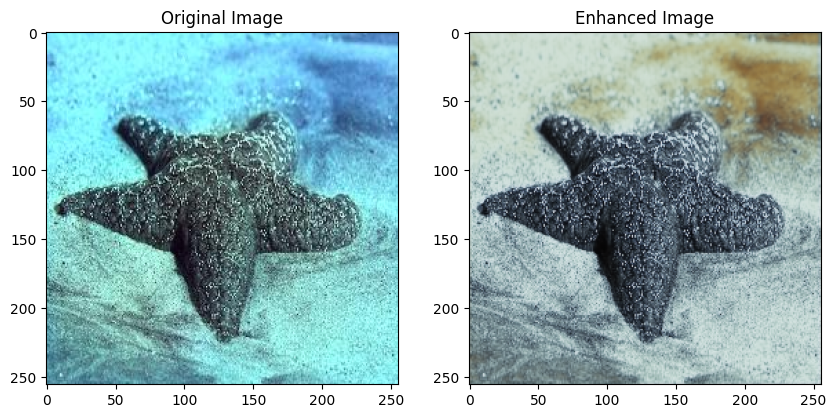

In [2]:
# Enhance an example image
def enhance_image(model, img_path, img_size):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    enhanced_img_array = model.predict(img_array)[0]
    enhanced_img = (enhanced_img_array * 255).astype(np.uint8)
    return enhanced_img

example_img_path = '/kaggle/input/underwaterimages/underwater_dark/validation/264290_n02317335_33797.JPEG'
enhanced_img = enhance_image(model, example_img_path, img_size)

# Display the original and enhanced images
original_img = cv2.imread(example_img_path)
original_img = cv2.resize(original_img, img_size)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
plt.show()